In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## Leer el dataset

In [2]:
data = pd.read_csv('/content/vehicles.csv')

df = pd.DataFrame(data)

###1. Carga y Exploración de Datos:

* Realizar una exploración inicial para entender la estructura del dataset.
* Identificar valores faltantes, duplicados y outliers.



In [3]:
##Exploracion inicial
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

In [4]:
# Identificar valores faltantes
def identificar_valores_faltantes(df):
    print("Valores faltantes en el dataset")
    qsna = df.shape[0] - df.isnull().sum(axis=0)
    qna = df.isnull().sum(axis=0)
    ppna = round(100 * (df.isnull().sum(axis=0) / df.shape[0]), 2)

    # Crear DataFrame con los resultados
    aux = {'datos sin NAs en q': qsna, 'Na en q': qna, 'Na en %': ppna}
    na_df = pd.DataFrame(data=aux)

    # Ordenar el DataFrame por el porcentaje de valores faltantes
    return na_df.sort_values(by='Na en %', ascending=False)

na_df = identificar_valores_faltantes(df)
print(na_df)

df=df.drop(columns=['county','size'])
### Se elimina county y size ya que los mismos tienen un alto indice de valores nulos




Valores faltantes en el dataset
              datos sin NAs en q  Na en q  Na en %
county                         0   426880   100.00
size                      120519   306361    71.77
cylinders                 249202   177678    41.62
condition                 252776   174104    40.79
VIN                       265838   161042    37.73
drive                     296313   130567    30.59
paint_color               296677   130203    30.50
type                      334022    92858    21.75
manufacturer              409234    17646     4.13
title_status              418638     8242     1.93
lat                       420331     6549     1.53
long                      420331     6549     1.53
model                     421603     5277     1.24
odometer                  422480     4400     1.03
fuel                      423867     3013     0.71
transmission              424324     2556     0.60
year                      425675     1205     0.28
image_url                 426812       68     0.02

In [5]:
## Se imputan valores nulos con pipeline de preprocesamiento###

##Verificacion de elementos duplicados
###
print("Cantidad de filas duplicadas antes de la eliminacion: ",df.duplicated().sum())
## No se observan datos duplicados por lo que no es necesario eliminarlos

Cantidad de filas duplicadas antes de la eliminacion:  0


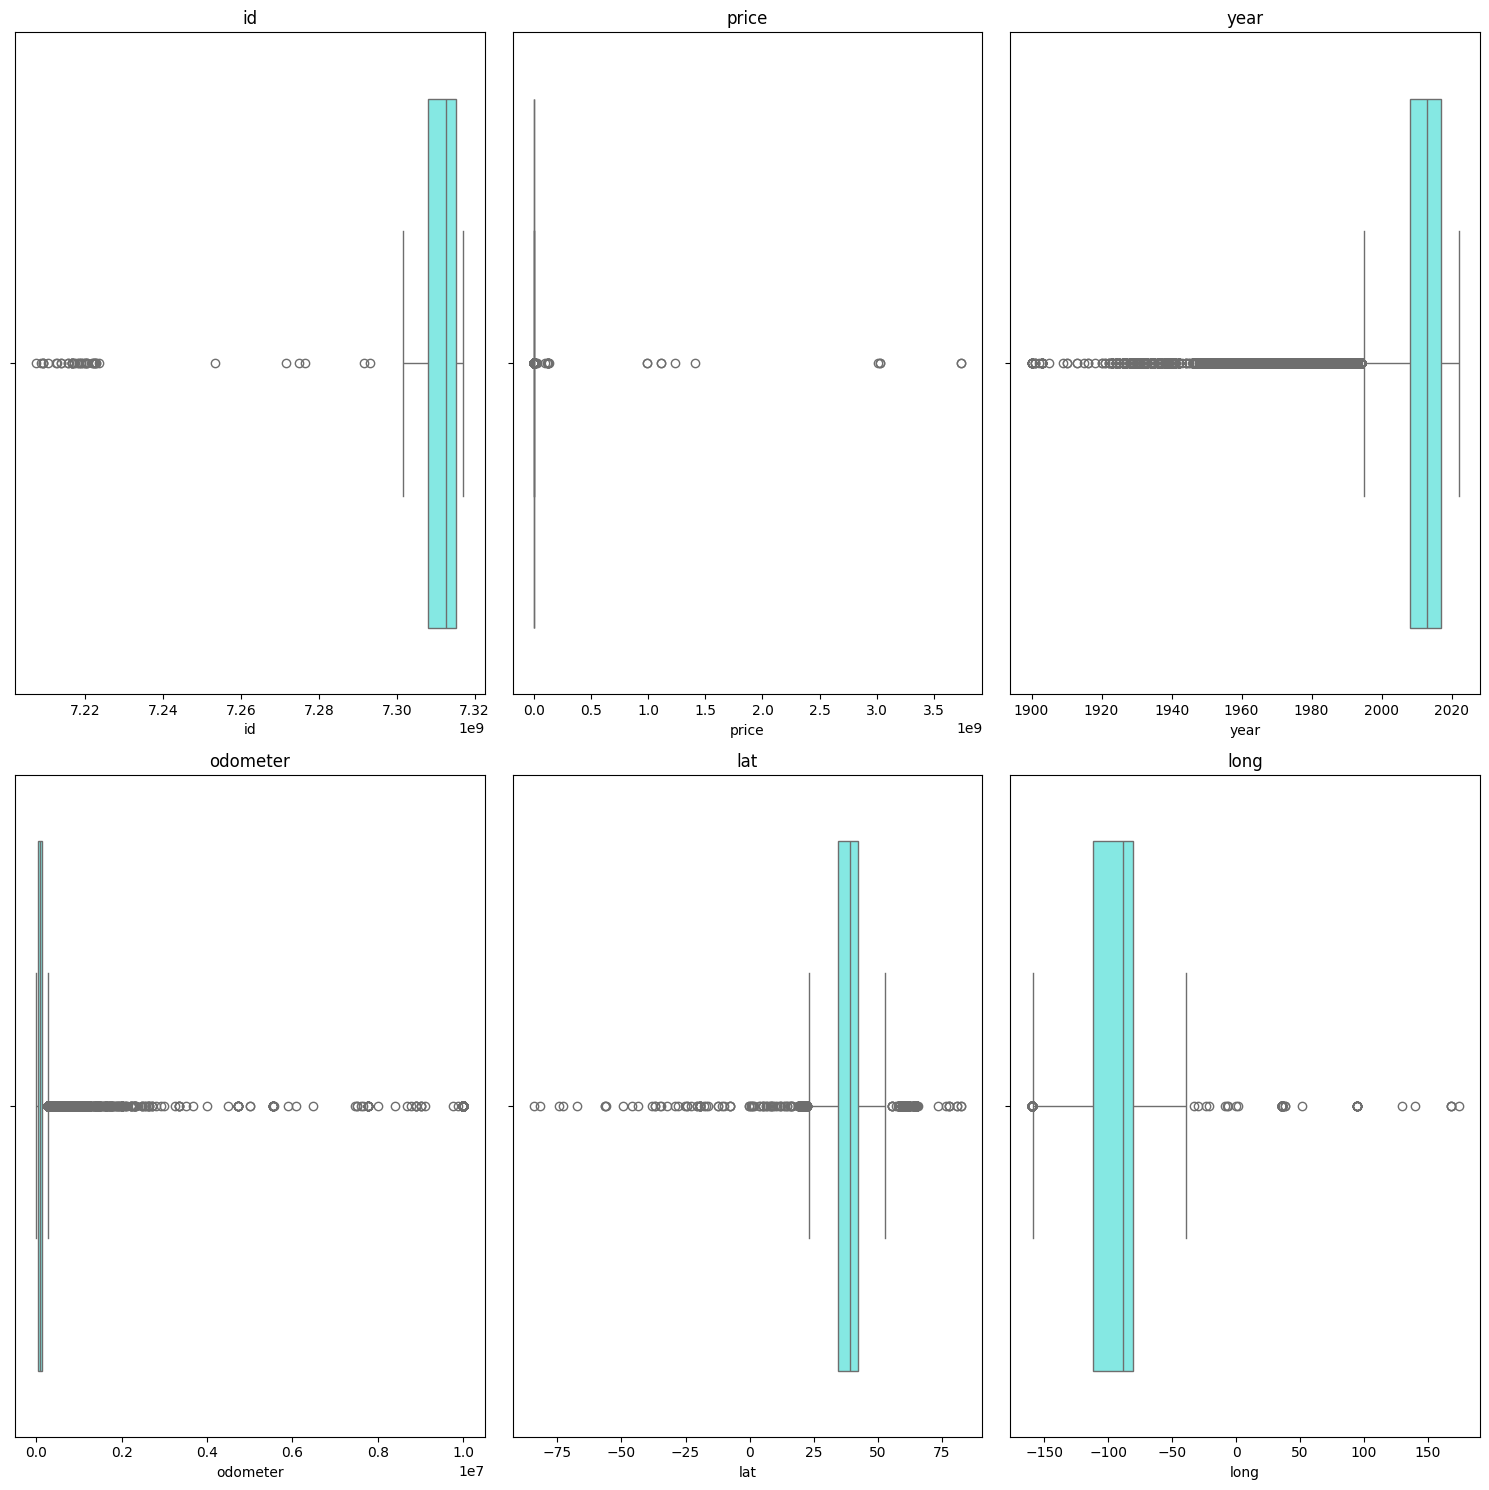

In [6]:
### Verificacion de outliers
num_features = df.select_dtypes(include=['int64', 'float64'])
def plot_grafico_outliers(num_features, df):

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))

    for i, feature in enumerate(num_features):
        row, col = divmod(i, 3)
        sns.boxplot(x=df[feature], ax=axes[row, col], color="#75f8f2")
        axes[row, col].set_title(feature)

    plt.tight_layout()
    plt.show()
plot_grafico_outliers(num_features,df)

##### Se encuentra presencias de outliers, sin embargo ya que estamos realizando una clasificicacion lineal, considero que estos valores serian valiosos para determinar los precios mas altos. Se considera el escalamiento para mejorar este aspecto.

 ### 2. Limpieza y Preprocesamiento:

* Manejar valores faltantes.
* Eliminar duplicados.
* Corregir inconsistencias en los datos categóricos.
* Escalar las características numéricas.
* Realizar transformaciones necesarias para las características categóricas.


In [7]:
##Verificacion de elementos duplicados
print("Cantidad de filas duplicadas antes de la eliminacion: ",df.duplicated().sum())
## No se observan datos duplicados por lo que no es necesario eliminarlos

Cantidad de filas duplicadas antes de la eliminacion:  0


In [8]:
def contar_valores_categoricos(df):
    # Recorre las columnas categóricas del DataFrame
    for col in df.select_dtypes(include=['object', 'category']):
        print(f'Valores únicos en la columna: {col}')
        print(df[col].value_counts())
        print('-' * 50)

contar_valores_categoricos(df)
### No se observan datos categoricos a los cuales se tengan que modificar por ser inconsistentes como City Hotel y Citi Hotel, por lo que se procede a ponerlos todos en minusula
##Se cambiar str to upper y strip utilizando metodo apply.
df.apply(lambda x: x.astype(str).str.lower().str.strip())

Valores únicos en la columna: url
url
https://prescott.craigslist.org/cto/d/prescott-2010-ford-ranger/7222695916.html                     1
https://nh.craigslist.org/cto/d/troy-1998-dodge-ram-59-cummins/7313139418.html                      1
https://nh.craigslist.org/ctd/d/north-hampton-2012-hyundai-sante-fe-se/7313423023.html              1
https://nh.craigslist.org/ctd/d/derry-2008-chrysler-sebring-limited-all/7313423324.html             1
https://nh.craigslist.org/ctd/d/derry-2002-toyota-camry-low-miles/7313424533.html                   1
                                                                                                   ..
https://chicago.craigslist.org/chc/cto/d/pleasant-prairie-2015-f80-m3-700hp-many/7314655506.html    1
https://chicago.craigslist.org/wcl/cto/d/saint-charles-2013-ford-focus-titanium/7314655833.html     1
https://chicago.craigslist.org/nwc/cto/d/northbrook-runner-ltd-4x4-owner/7314657468.html            1
https://chicago.craigslist.org/sox/cto/d/chi

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,VIN,drive,type,paint_color,image_url,description,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,az,nan,nan,nan
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,ar,nan,nan,nan
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,fl,nan,nan,nan
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central ma,https://worcester.craigslist.org,1500,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,ma,nan,nan,nan
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nc,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,7301591192,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,...,1n4aa6av6kc367801,fwd,sedan,nan,https://images.craigslist.org/00o0o_iirafnhg8q...,carvana is the safer way to buy a car during t...,wy,33.7865,-84.4454,2021-04-04t03:21:31-0600
426876,7301591187,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,nan,...,7jr102fkxlg042696,fwd,sedan,red,https://images.craigslist.org/00x0x_15sbgnxcis...,carvana is the safer way to buy a car during t...,wy,33.7865,-84.4454,2021-04-04t03:21:29-0600
426877,7301591147,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,34990,2020.0,cadillac,xt4 sport suv 4d,good,nan,...,1gyfzfr46lf088296,nan,hatchback,white,https://images.craigslist.org/00l0l_farm7bxnxr...,carvana is the safer way to buy a car during t...,wy,33.779214,-84.411811,2021-04-04t03:21:17-0600
426878,7301591140,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,...,58abk1gg4ju103853,fwd,sedan,silver,https://images.craigslist.org/00z0z_bknivglkdt...,carvana is the safer way to buy a car during t...,wy,33.7865,-84.4454,2021-04-04t03:21:11-0600


In [9]:
# Definir X e y. Dividir los datos en conjunto de entrenamiento y prueba

X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [10]:
###Pipeline para preprocesamiento de valores
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()  # Get column names
categorical_features = X.select_dtypes(include=['object']).columns.tolist() # Get column names
# Crear transformadores para cada subconjunto de columnas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Colocar nombres como strings
    ('scaler', StandardScaler())
])

# Crear transformer para columnas categóricas con imputación
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='desconocido')),  # Imputar valores faltantes
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Codificar categorías
])

# Combinar transformaciones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Integrar en un pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Crear y aplicar el pipeline a los datos de entrenamiento
X_train_transformed = pipeline.fit_transform(X_train)

# Aplicar la misma transformación a los datos de prueba (sin hacer fit)
X_test_transformed = pipeline.transform(X_test)

print("Preprocesamiento completado. Datos transformados listos para modelar.")

Preprocesamiento completado. Datos transformados listos para modelar.


 3. Exploración de Datos:

* Crear visualizaciones univariadas y multivariadas.
* Calcular estadísticas descriptivas.


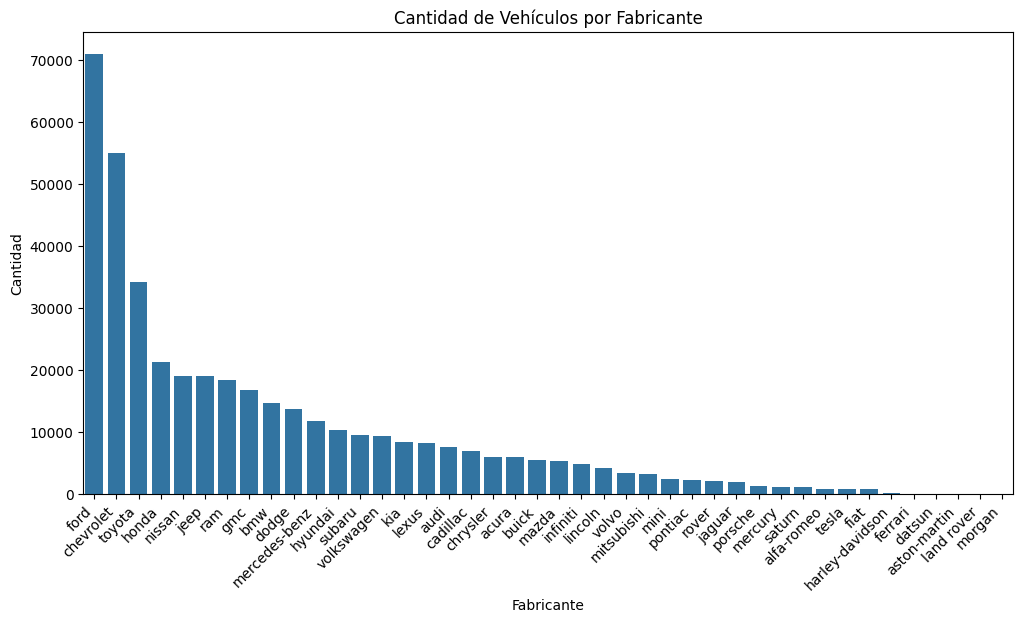

In [11]:
### Plot de univariadas
plt.figure(figsize=(12, 6))
sns.countplot(x=df['manufacturer'], order=df['manufacturer'].value_counts().index)
plt.title('Cantidad de Vehículos por Fabricante')
plt.xlabel('Fabricante')
plt.ylabel('Cantidad')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
### Multivariante ### Colab no deja imprimir y tampoco en mi pc personal deja correr este grafico
plt.figure(figsize=(8, 6))
sns.histplot(x='odometer', y='price', data=df)
plt.title('Relación entre Precio y Kilometraje')
plt.xlabel('Kilometraje')
plt.ylabel('Precio')
plt.show()

4. Modelado y Evaluación:

* Implementar al menos dos modelos de regresión (Linear Regression y Random Forest Regressor).
* Evaluar los modelos utilizando MSE, RMSE, y R^2.
* Seleccionar el mejor modelo basado en las métricas de evaluación.


In [12]:
# Crear y entrenar el modelo de regresión lineal
modelo = LinearRegression()
modelo.fit(X_train_transformed, y_train)

# Realizar predicciones
y_pred = modelo.predict(X_test_transformed)

# Evaluar el modelo
mseLR = mean_squared_error(y_test, y_pred)
r2LR = r2_score(y_test, y_pred)
RMSELR = np.sqrt(mseLR)

print(f'Error Cuadrático Medio: {mseLR}')
print(f'R-cuadrado: {r2LR}')
print(f'Raíz del Error Cuadrático Medio: {RMSELR}')


Error Cuadrático Medio: 12846334810027.88
R-cuadrado: -0.0570482698398278
Raíz del Error Cuadrático Medio: 3584178.4009766984


In [ ]:
# Entrenar el modelo RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_transformed, y_train)

# Realizar predicciones
y_pred = rf.predict(X_test_transformed)

# Evaluar el modelo
mseDT = mean_squared_error(y_test, y_pred)
r2DT = r2_score(y_test, y_pred)
RMSEDT = np.sqrt(mseDT)

print(f'Error Cuadrático Medio: {mseDT}')
print(f'R-cuadrado: {r2DT}')
print(f'Raíz del Error Cuadrático Medio: {RMSEDT}')

In [ ]:
### Definir los hyperparametros para  RF y LR
param_grid_rf = {
    'n_estimators': [20, 30],
    'max_depth': [None, 10],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [2, 4]
}
param_grid_lr = {
    'fit_intercept': [True, False],
    'positive': [False, True] #solo si se esperan resultados positivos
}

In [ ]:
##Instanciar Gridsearch Crea un objeto GridSearchCV con el modelo, la grilla de parámetros y la métrica de evaluación que deseas usar.
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf,
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search_lr = GridSearchCV(estimator=modelo, param_grid=param_grid_lr,
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

In [ ]:
##Entrena modelo RF
grid_search_rf.fit(X_train_transformed, y_train)

In [ ]:
##Entrena modelo LR
grid_search_lr.fit(X_train_transformed, y_train)

In [ ]:
###Obtener los mejores hyperparametros
best_params_rf = grid_search_rf.best_params_
best_params_lr = grid_search_lr.best_params_

print("Mejores hiperparámetros para Random Forest:", best_params_rf)
print("Mejores hiperparámetros para Linear Regression:", best_params_lr)

In [ ]:
###Evaluar los mejores Hyperparametros
best_rf = grid_search_rf.best_estimator_
best_lr = grid_search_lr.best_estimator_

y_pred_rf = best_rf.predict(X_test_transformed)
y_pred_lr = best_lr.predict(X_test_transformed)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_rf = r2_score(y_test, y_pred_rf)
r2_lr = r2_score(y_test, y_pred_lr)
RMSELR = np.sqrt(mseLR)
RMSERF = np.sqrt(mse_rf)